In [3]:
import detect_heds_module_path
from holoeye import slmdisplaysdk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import time
from pypylon import pylon

shape is:  (1080, 1920)
dataWidth = 1920
dataHeight = 1080
[[3.46024099 2.5672829  3.51420156 ... 1.99821819 6.2426843  2.01295841]
 [4.31167132 3.25120947 5.24944154 ... 5.26820625 3.89882076 0.52888999]
 [5.23146661 4.92103032 0.76056158 ... 5.60794818 2.44826511 0.38667391]
 ...
 [4.15953393 0.33823295 5.63897279 ... 1.4256337  0.22284505 3.03041672]
 [4.86024572 3.07636247 3.07536705 ... 0.69713723 0.63240579 3.84319185]
 [5.2609474  0.5755943  5.52304558 ... 0.56949591 3.86124161 5.02587784]]


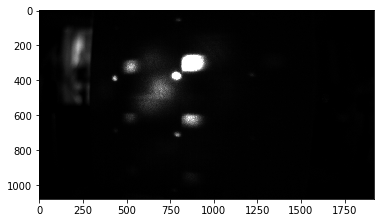

In [51]:
camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())
camera.Open()
new_width = camera.Width.GetValue() - camera.Width.GetInc()
if new_width >= camera.Width.GetMin():
    camera.Width.SetValue(new_width)


#datafile = open('file.csv', 'r')
#datareader = csv.reader(datafile, delimiter=';')
#data = []
#for row in datareader:
 #   data.append(row)
#data2 = np.asarray(data)
#w,h = data2.shape

# Make some enumerations available locally to avoid too much code:
ErrorCode = slmdisplaysdk.SLMDisplay.ErrorCode
ShowFlags = slmdisplaysdk.SLMDisplay.ShowFlags

# Initializes the SLM library
slm = slmdisplaysdk.SLMDisplay()

# Check if the library implements the required version
if not slm.requiresVersion(2):
    exit(1)

# Detect SLMs and open a window on the selected SLM
error = slm.open()
assert error == ErrorCode.NoError, slm.errorString(error)

# Open the SLM preview window in "Fit" mode:
# Please adapt the file showSLMPreview.py if preview window
# is not at the right position or even not visible.
from showSLMPreview import showSLMPreview
#showSLMPreview(slm, scale=0.0)

# Calculate e.g. a vertical blazed grating:
blazePeriod = 77

# Reserve memory for the data:
dataWidth = slm.width_px
dataHeight = slm.height_px
data = slmdisplaysdk.createFieldUChar(dataWidth, dataHeight)
#print(data)
print("shape is: ", data.shape)
print("dataWidth = " + str(dataWidth))
print("dataHeight = " + str(dataHeight))

# Calculate the data:
data = 2*np.pi*np.random.uniform(0,255,(dataWidth, dataHeight))/255
print(data)
#Change Threshold
COST = 999999999999999999
Threshold = 0.1
a = 0.5
def cost(I_target, I_camera):
    return np.sum((abs(I_target-I_camera))**2)/np.size(I_target)

##Set this appropriately, can load the .npy file into this, and resize probably
TargetIntensity = np.load('target_intensity.npy')

plt.imshow(TargetIntensity, cmap='gray', vmin=0, vmax=255)
plt.show()    

In [52]:
numberOfImagesToGrab = 1000
iter = 0
new_target = TargetIntensity.T
camera.StartGrabbingMax(numberOfImagesToGrab)
time_start = time.time()
while camera.IsGrabbing() and (COST>Threshold):
    error = slm.showData(data)
    grabResult = camera.RetrieveResult(5000, pylon.TimeoutHandling_ThrowException)

    if grabResult.GrabSucceeded():
        # Access the image data.
        img = (np.asarray(grabResult.Array))**0.5 #.reshape((grabResult.Height, grabResult.Width))
        img_sliced = img[0:1080, 0:1920]
        new_img = img_sliced.T
        COST = cost(new_target, new_img**2)

        
        img_fb = np.fft.fftshift(np.fft.ifft2((a*new_img+(1-a)*(new_target)**0.5)*(np.cos(data) + 1j*np.sin(data)))) # Multiplying phase mask to output electric field amplitude
        img_fb_phase = np.angle(img_fb)

        #print(img.shape)
        #print(data.shape)
        #img_fb_phase.T

        data = img_fb_phase
        iter = iter + 1

    time2 = time.time()
    #print("TIME: ", time2-time_start)
    ##Wait statements
    #time.sleep(5)
    #input("Press Enter to continue...")

    grabResult.Release()
    
print("TIME: ", time2-time_start)
print("Converged in ", iter , " iterations")

TIME:  160.34797954559326
Converged in  10  iterations


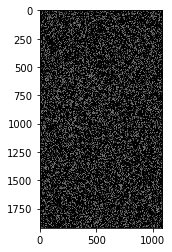

In [53]:
data = data*255/(2*np.pi)
plt.imshow(data, cmap='gray', vmin=0, vmax=255)
np.save('algo_test_result', data)

In [50]:
camera.Close()

# If your IDE terminates the python interpreter process after the script is finished, the SLM content
# will be lost as soon as the script finishes.
# You may insert further code here.
slm.close()
# Wait until the SLM process is closed:
error = slm.utilsWaitUntilClosed()
assert error == ErrorCode.NoError, slm.errorString(error)
# Unloading the SDK may or may not be required depending on your IDE:
slm = None


AssertionError: b'The SLM could not be initialized or was disconnected.'

In [31]:
print(data.shape)
print(img_sliced.shape)
print(TargetIntensity.shape)

(1920, 1080)
(1080, 1920)
(1080, 1920)


In [56]:
import os
cwd = os.getcwd()
print(cwd)

C:\Users\Ramesh
